### 경제 데이터 확인
* API 경유 정형 데이터 획득, 저장, 부분 업데이트, 시각화 및 상관관계 파악을 수행하고자 함
* 고수준 라이브러리를 이용해 거시지표의 값을 예상하고자 함

#### 데이터 로드
* da.py에는 FRED와 Yahoo Finance의 API를 이용해 특정 획득, 부분 업데이트, 저장하는 getdata 메서드가 있음
* FRED와 Yahoo Finance에서 자기가 원하는 series를 티커 또는 ID로 추가할 수 있음
* 처음 실행시 f.csv가 있어야 하며, 일부 라이센스드 데이터는 직접 스크래핑해야 함

In [107]:
from da import *
data=getdata(-1,save=True)
data.info()

[*********************100%%**********************]  16 of 16 completed
            us02y         uj          ks          sp
date                                                
2023-09-07   4.94  147.70900  2548.26001  4451.14014
2023-09-08   4.98  147.33099  2547.67993  4457.49023
2023-09-11    NaN  147.11301  2556.87988  4487.45996
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15958 entries, 1980-01-01 to 2023-09-11
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   adp     164 non-null    float64
 1   ahe     210 non-null    float64
 2   cb      6967 non-null   float64
 3   cci     523 non-null    float64
 4   ci      523 non-null    float64
 5   cl      5786 non-null   float64
 6   djia    2516 non-null   float64
 7   fert    512 non-null    float64
 8   fr      15957 non-null  float64
 9   fs      1549 non-null   float64
 10  gdp     174 non-null    float64
 11  hg      5781 non-null   float64
 12  hi      438 non

#### 상관관계 확인
* da.py에는 상관계수 heatmap을 그리는 hm 래퍼 매서드가 있음
* 상관계수 확인은 EDA에서 자주 이루어지지만 한계가 명확함
    * 인과관계가 아님
    * 선형관계가 아니면 상관 정도가 과소평가됨
    * 특히, daily closing price인 상품 가격은 상관관계가 크게 왜곡됨

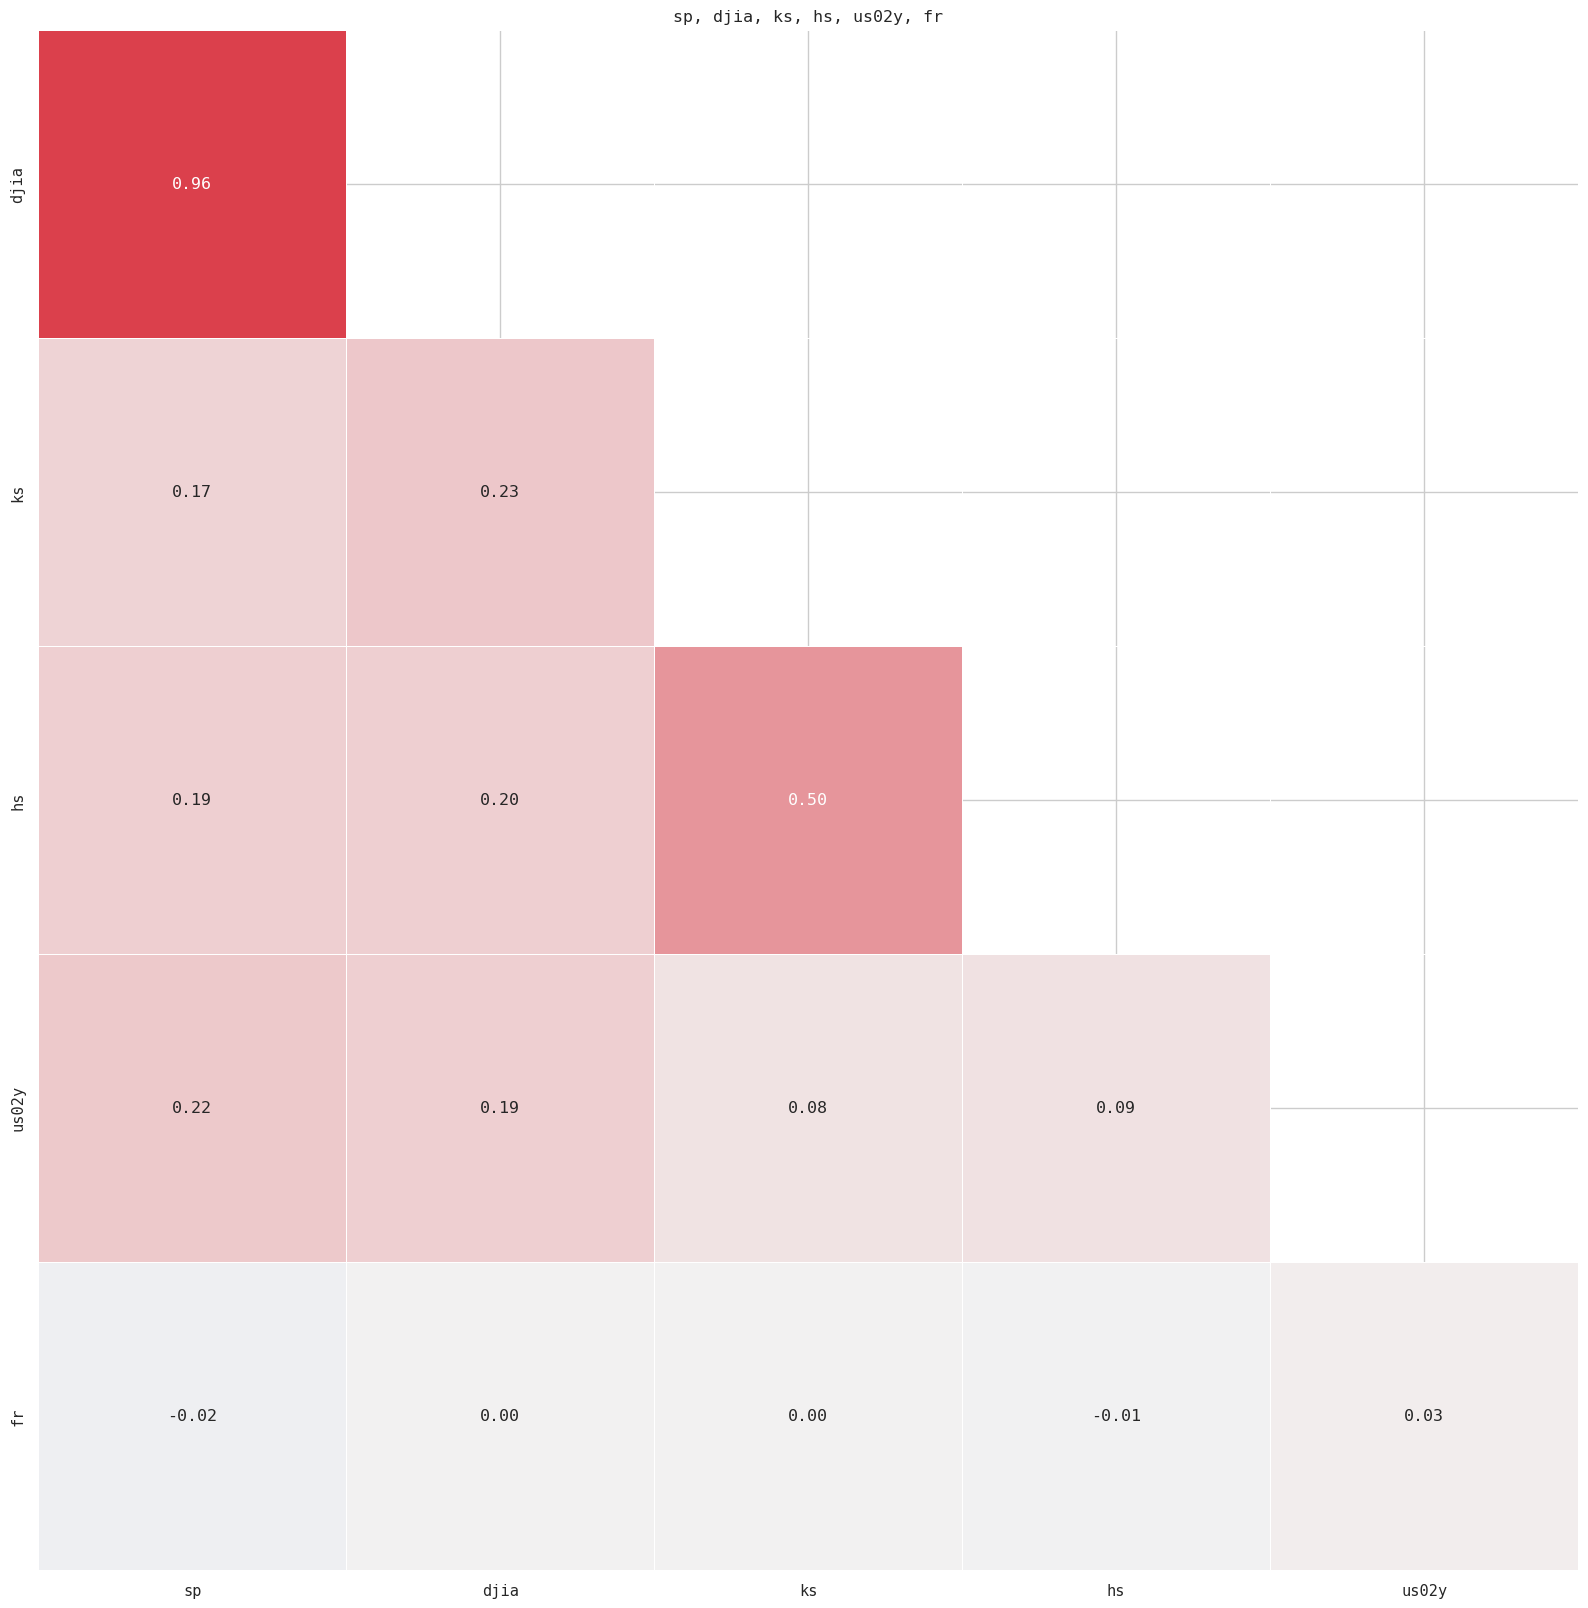

In [108]:
targets=["sp","djia","ks","hs","us02y","fr"]
_data=data[targets].interpolate(limit_area="inside",limit=1).dropna(subset=["sp","ks","hs"]).pct_change()[1:]
hm(_data.corr())


* 국채 2년물 일드 변화율과 주가지수 변화율이 양의 상관계수를 가짐
* 고시금리(SOFR) 변화율과 국채 일드 변화율이 상관계수가 크지 않음
    * SOFR이 절삭 평균의 고시성 가격으로 일일 변화가 드물기 떄문이며, 타임프레임을 확대하면 상관계수가 커짐
* 주가지수 변화율 간 상관계수가 크지 않음
    * Session overlapping을 고려하지 않았기 때문임

#### 래깅 상관계수
* t-1장(야간장)의 결과가 t장(주간장)에 영향을 주는 이른바 spillover effect를 확인하고자 함

(array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5]),
 array([-0.00231374,  0.01314393,  0.02630355,  0.09913082,  0.29957902,
         0.16309004,  0.01609317, -0.00522525, -0.01937012, -0.01215211,
        -0.00236505]),
 <matplotlib.lines.Line2D at 0x269a8d1b4d0>)

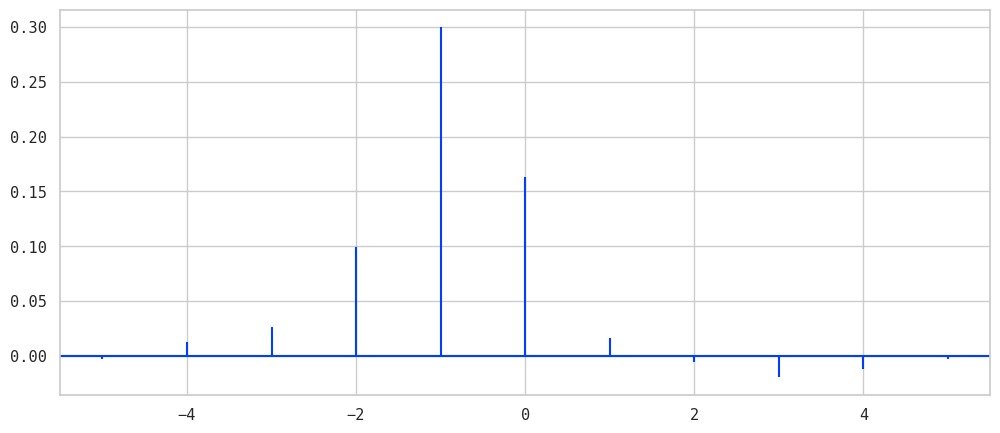

In [109]:
targets=["sp","ks"]
_data=data[targets].interpolate(limit_area="inside",limit=1).dropna().pct_change()[1:]
plt.xcorr(_data.sp,_data.ks,maxlags=5)

* 주간장 변화율을 -1일 이동했을 때 야간장 변화율에 대해 0.3의 가장 큰 상관계수를 가짐
    * 전기간 데이터에 대해, 오히려 주간장이 야간장 변화율에 영향을 주고 있음

#### 고용지표
* 아래 3종 고용지표를 다루고자 함
    * ur(unrate): 실업률. 변화율 변동성이 작지만 대표성이 높음
    * pr(nfp): Nonfarm Payrolls. 월간 새로 생성된 일자리의 개수임
    * ic(icsa): Inicial Claims. 주간 실업수당 청구의 개수로, 1주일밖에 후행적이지 않음
* 고용지표는 해당 기간의 GDP 변화율을 결정하는 중대한 요인임

<Axes: xlabel='date'>

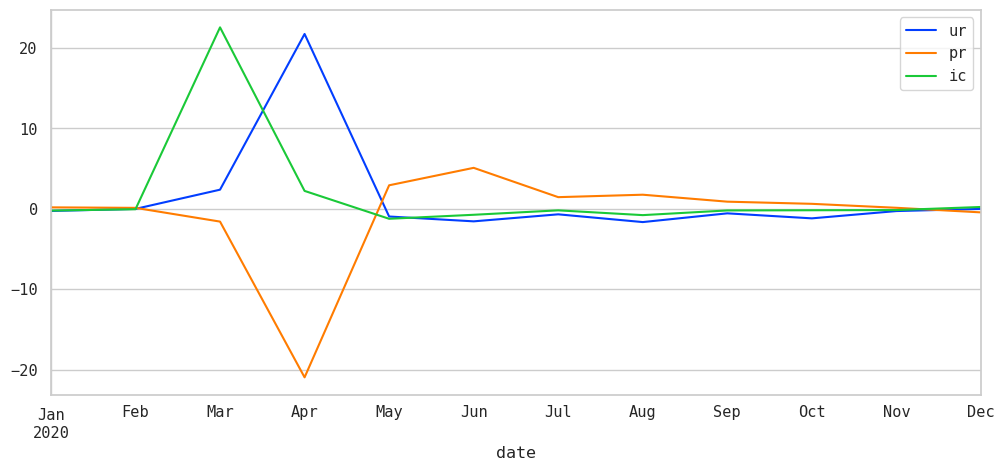

In [110]:
targets=["ur","pr","ic"]
_data=data[targets].resample("m").mean().pct_change()[1:]
_data=scipy.stats.zscore(_data,nan_policy="omit")
_data.loc["2020"].plot()

* ICSA, PR, UR 순으로 노동시장 악화가 확인됨
    * 2023-03의 경우 layoff가 신속한 서비스업이 주로 타격을 받아 이런 경향이 뚜렷함

<Axes: xlabel='date'>

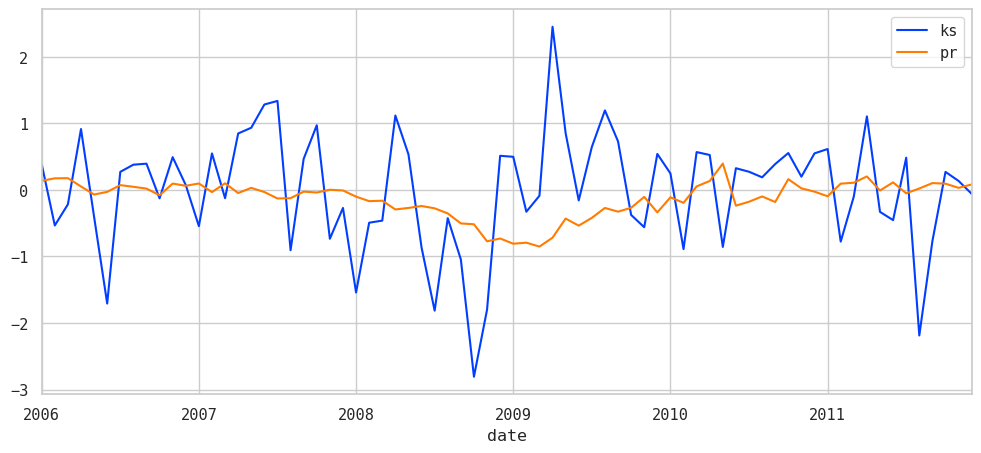

In [111]:
targets=["ks","pr"]
_data=data[targets].resample("m").mean().pct_change().dropna()
_data=scipy.stats.zscore(_data)
_data.loc["2006":"2011"].plot()

* 주가지수 변화율은 당월 발표되는 전월 NFP 변화율과 양의 상관관계를 가짐

<Axes: xlabel='date'>

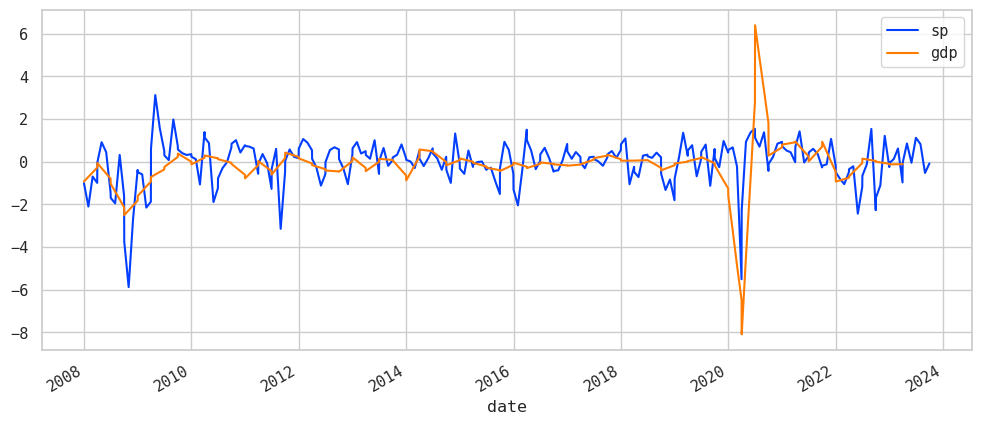

In [112]:
sp=data.sp.resample("m").mean().pct_change(fill_method=None)
gdp=data.gdp.dropna().pct_change(fill_method=None)
sp_to_gdp=scipy.stats.zscore(pd.concat([sp,gdp],axis=1).dropna(how="all"),nan_policy="omit").interpolate(limit_area="inside")
sp_to_gdp.loc["2008":].plot()

* 주가지수 변화율이 고용지표 변화율과 양의 상관관계를 가지므로, GDP 변화율과도 양의 상관관계를 가짐

#### 가격지표
* 가장 중요한 CPI 및 Core CPI 위주로 다루고자 함
    * CPI Basket에서 변동성이 큰 부문을 제외하고 절삭 평균(trimmed mean) 또는 부문별 가중(weighting)으로 산출한 지표가 core 또는 PCE임
    * 당국의 2% Inflation Target은 Core PCE YoY 2%를 말함
    * PCE, PPI는 발표 순서상 CPI보다 중요도가 떨어짐

<Axes: xlabel='date'>

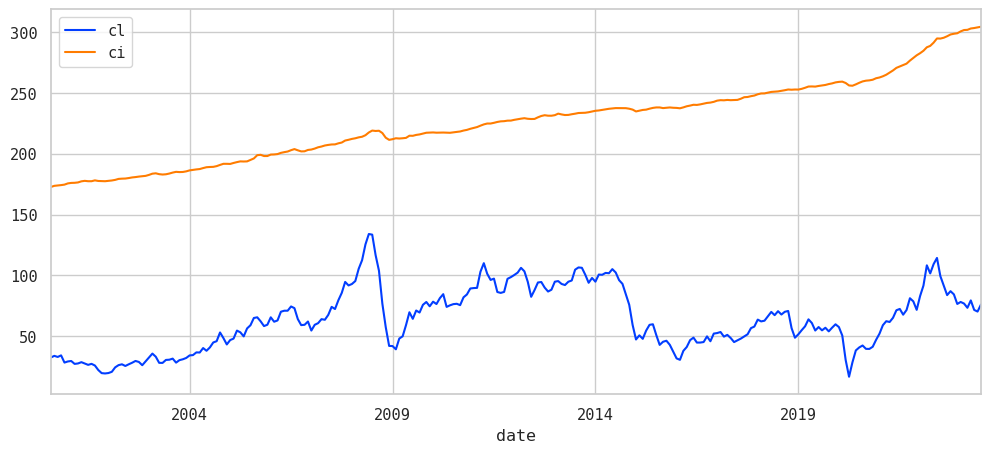

In [113]:
data[["cl","ci"]].resample("m").mean().dropna().plot()

* CPI의 변화율이 아닌 가격 그 자체임에도 원유 가격과의 상관성이 드러남
    * 원유 가격 변화율만으로 CPI 변화율의 정도를 예측 가능함

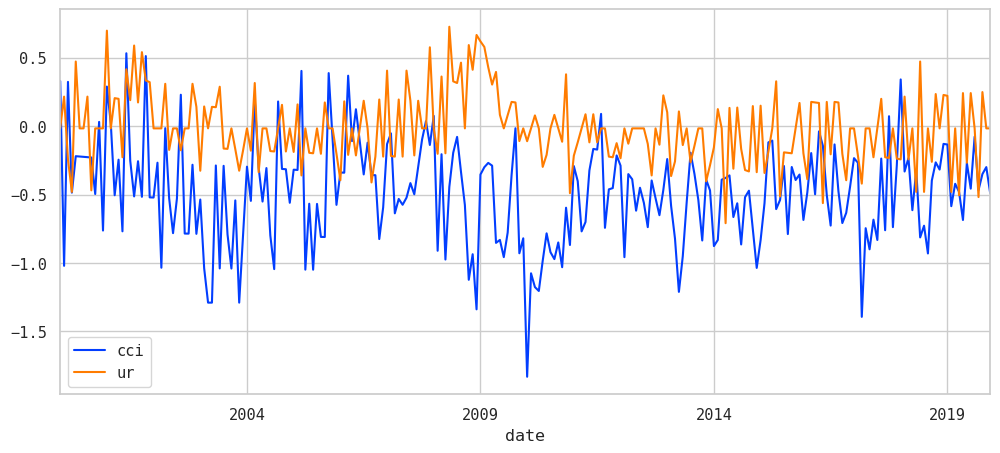

c:\prog\lib\miniconda\envs\org\Lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


(array([-3, -2, -1,  0,  1,  2,  3]),
 array([nan, nan, nan, nan, nan, nan, nan]),
 <matplotlib.lines.Line2D at 0x269a4fe7450>)

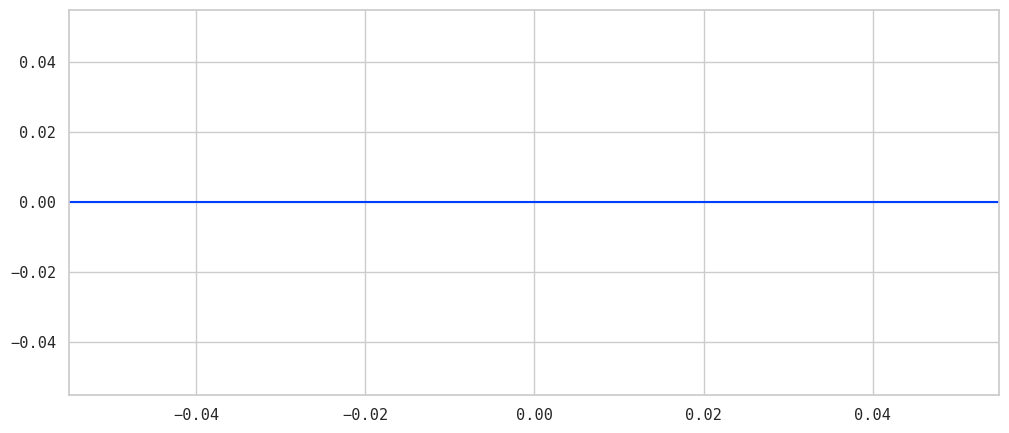

In [114]:
_data=scipy.stats.zscore(data[["cci","ur"]].resample("M").mean().pct_change(fill_method=None).dropna(how="all"),nan_policy="omit")
_data.loc["2000":"2019"].plot(),plt.show()
plt.xcorr(_data.cci,_data.ur,maxlags=3)

* Core CPI와 실업률에는 약한 음의 상관관계가 있음
    * 2022년 이래의 기간적 맥락에서는 상관관계가 -0.3 정도로 강해짐

#### 비정상성과 랜덤워크
* 명목 가격은 시간이 경과하며 증가하는 시장 유동성에 따라 상승하므로 정상성이 없음
* 정상성은 ADF를 수행하거나 단순 플랏으로 확인할 수 있음

<Axes: xlabel='date'>

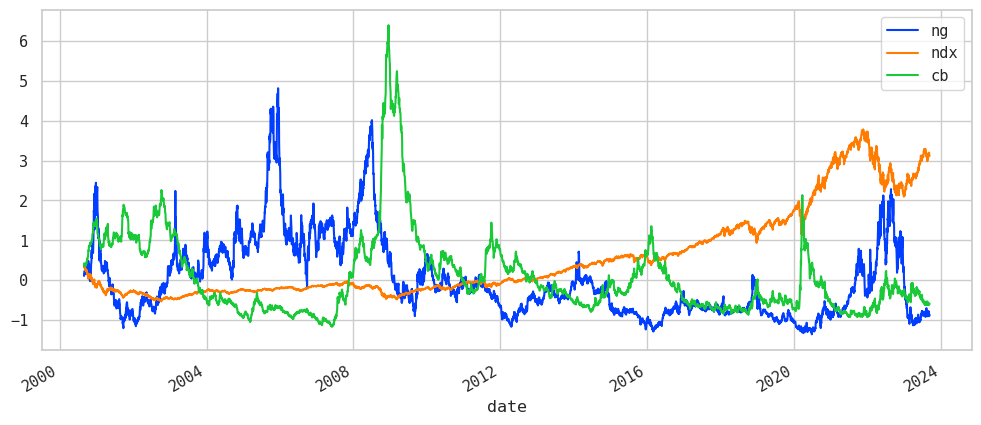

In [115]:
scipy.stats.zscore(data[["ng","ndx","cb"]],nan_policy="omit").dropna().plot()

* ng는 정상성이 있어 보임
    * 명목 가격이 평균 회귀 경향을 가지고 변동성이 큰 상품은 대단히 희귀함
* ndx는 정상성이 없음
* cb는 정상성이 있어 보임

<Axes: xlabel='date'>

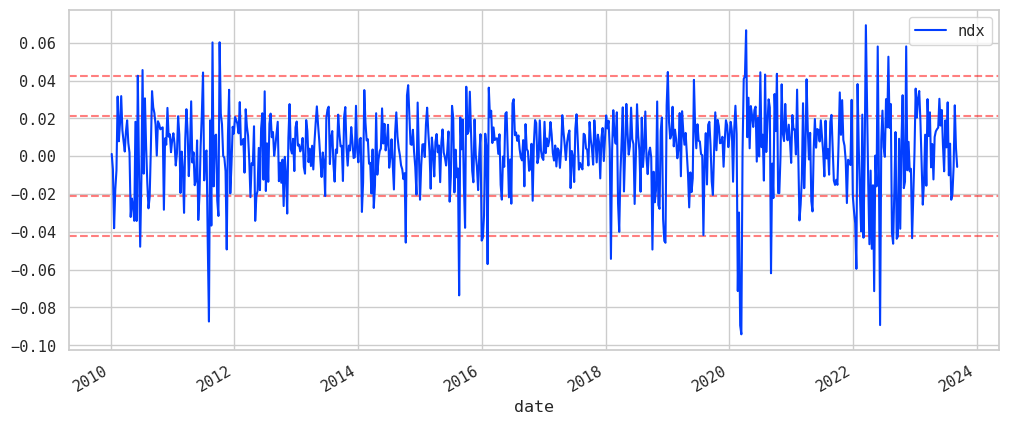

In [116]:
_data=data[["ndx"]].loc["2010":].resample("7d").mean().pct_change().dropna()
fg,ax=plt.subplots()
[ax.axhline(y=_data.ndx.std()*q,linestyle="dashed",alpha=.5,color="red") for q in (-2,-1,1,2)]
_data.plot(ax=ax)

* ndx의 변화율은 랜덤워크임
    * 적색 선은 ndx 변화율의 2010년 이후 기준 1, 2 시그마
* 특정 구간에서 price action이 발생함
    * 도래 지점까지 nominal price의 변동성 정도나 slope 특성을 규정하는 인자가 있음

#### 소매판매와 주가지수
* 당월 소매판매 변화율이 주가지수 변화율과 상관되는지 확인하고자 함

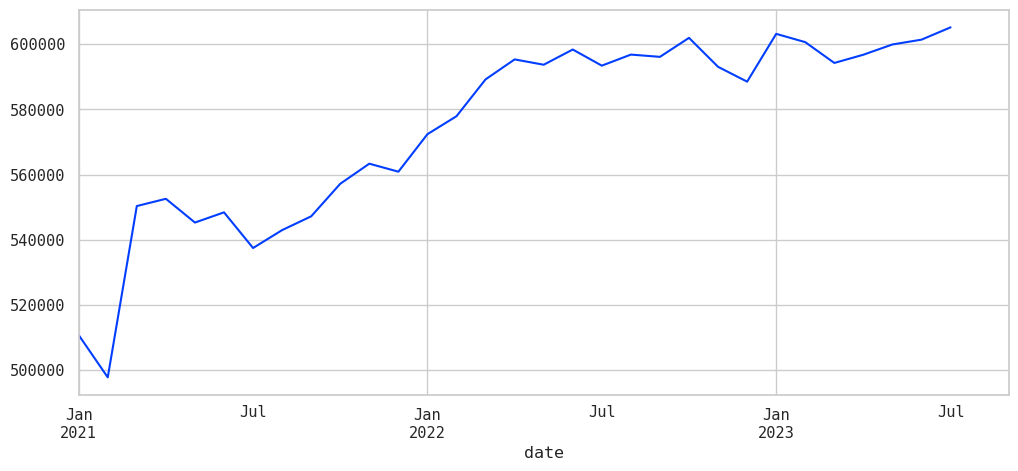

xcorr (-1, 0.36399847806696384)


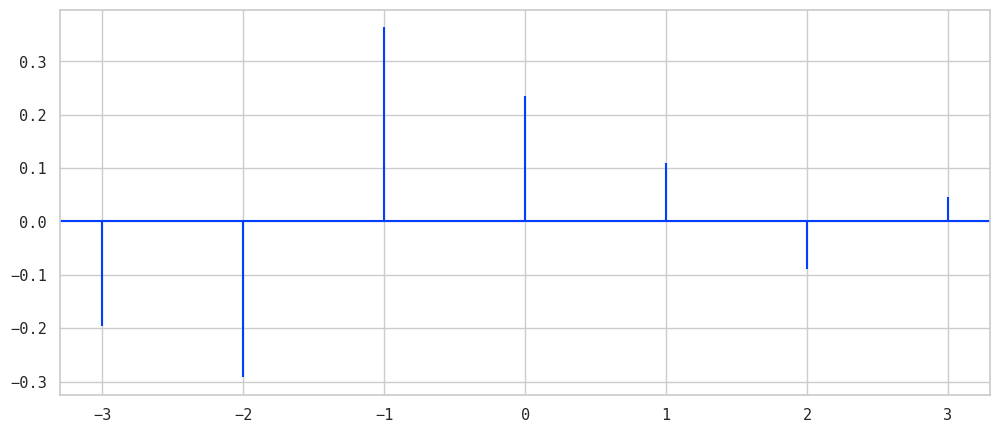

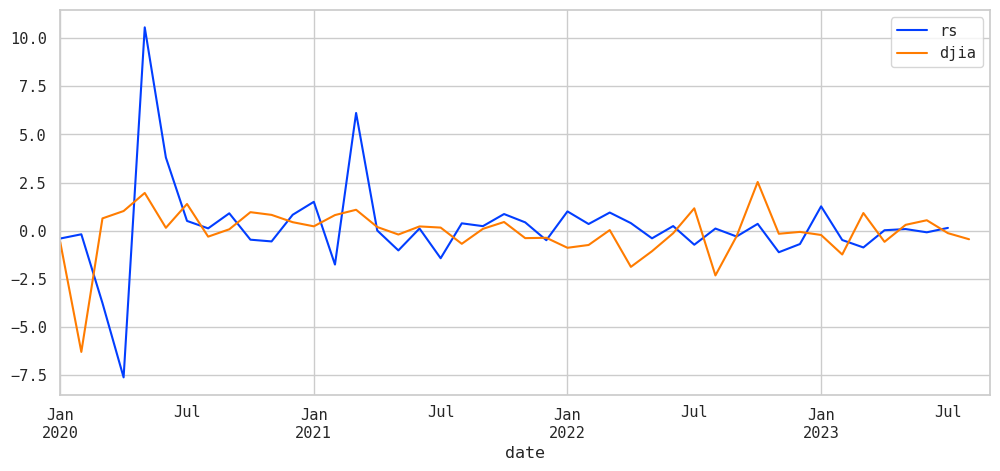

(<Axes: xlabel='date'>, None)

In [117]:
data.rs.resample("m").mean().loc["2021":].plot(),plt.show()
rs=data.rs.resample("m").mean().pct_change(fill_method=None).dropna()
djia=data.djia.resample("m").mean().pct_change()
lattice=scipy.stats.zscore(pd.concat([rs,djia],axis=1),nan_policy="omit").dropna(subset=["djia"])

djia_to_rs=plt.xcorr(lattice.dropna().djia,lattice.dropna().rs,maxlags=3)
djia_to_rs_idx=abs(djia_to_rs[1]).argmax()
print("xcorr",(djia_to_rs[0][djia_to_rs_idx],djia_to_rs[1][djia_to_rs_idx]))

lattice_=lattice.loc["2020":]
lattice_.djia=lattice_.djia.shift(-1)
lattice_.plot(),plt.show()

* 소매판매 변화율과 주가지수 변화율의 상관성은 뚜렷하지 않음

#### 회사채 일드 스프레드와 주간 실업수당 청구건수
* 회사채 일드 스프레드는 국채에 대한 회사채의 위험 수준을 나타냄
    * 회사 미래 매출과 배당에 대한 할인율임
    * 1일 후행적이면서 대표성이 높음
    * [모든 Recession Indicator에서 회사채 일드 스프레드를 사용하며 그것만으로도 Recession Indicator임](https://research.stlouisfed.org/publications/economic-synopses/2010/01/15/measuring-financial-market-stress/) 

<Axes: xlabel='date'>

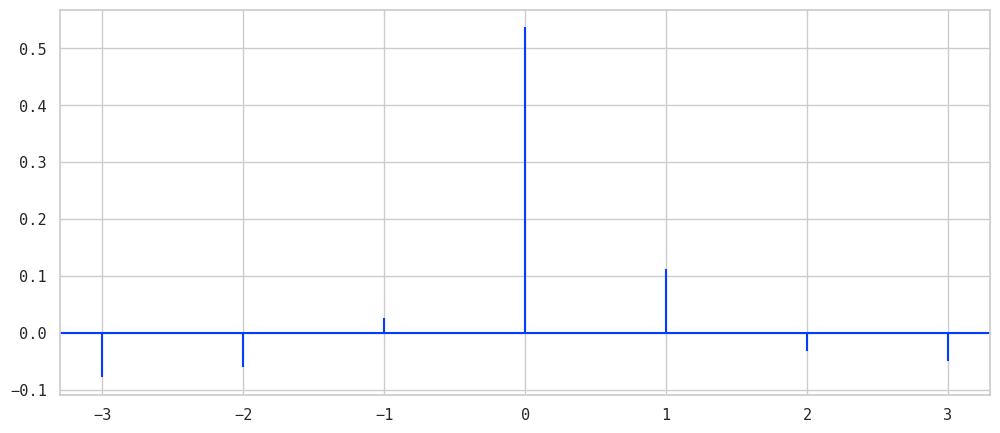

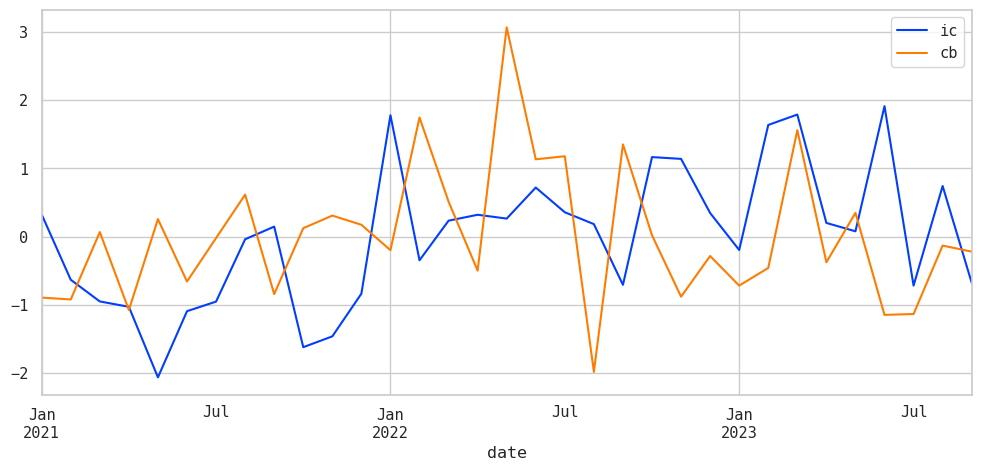

In [118]:
exam=data[["ic","cb"]].resample("m").mean().pct_change(fill_method=None)
exam_=exam.dropna()
plt.xcorr(exam_.ic,exam_.cb,maxlags=3)
scipy.stats.zscore(exam.loc["2021":],nan_policy="omit").plot()

* 회사채 일드 스프레드가 증가하면 주간 실업수당 청구건수가 증가함

#### 월간 생성 일자리 개수 예측
* 시장참가자의 관점에서 월간 일자리 생성 개수(NFP 델타, pr)는 명목 가격의 변화 추이를 결정하는 가장 중요한 요인임
* 상기 EDA를 통해 주간 실업수당 청구건수(ic)와 회사채 일드 스프레드(cb)의 적시성 및 대표성을 확인했으며, 이를 바탕으로 당월 발표되는 전월 NFP 델타의 변화율을 예측하고자 함

##### 진행 수순
* 클래스/매서드 임포트
* 전후처리
    * 집적, mean/median/std 확인
    * 차분, 변환, 표준화
    * 피처 디자인 매트릭스 생성
* 피처 변동성 확인
* 1000-Fold 이상으로 regularization (alpha) 값 산출
* 발표 시점까지의 데이터를 determinant로 NFP 델타 예측

In [295]:
from sklearn.model_selection import RepeatedKFold,cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

xy=data[["cb","ic","pr"]].resample("m").mean().dropna(subset=["cb"])
xy.pr=xy.pr.diff()
xy=xy.iloc[1:]
xy.agg(["mean","median","std"])

,cb,ic,pr
mean,5.38436,377228.97196,110.23125
median,4.70190,324400.00000,182.00000
std,2.55873,316913.90097,1222.61373


In [298]:
yj={serie:scipy.stats.yeojohnson(xy[serie].dropna()) for serie in xy.columns}
xy_yj_lambda={serie:yj[serie][1] for serie in yj}
xy_yj_data={q[0]:q[1][0] for q in yj.items()}
xy_yj_data["pr"]=np.append(xy_yj_data["pr"],np.nan)
xy_yj=pd.DataFrame(xy_yj_data)

In [299]:
xy_yj_zs=scipy.stats.zscore(xy_yj,nan_policy="omit")
x=xy_yj_zs.iloc[:-1,:2]
y=xy_yj_zs.iloc[:-1, 2]

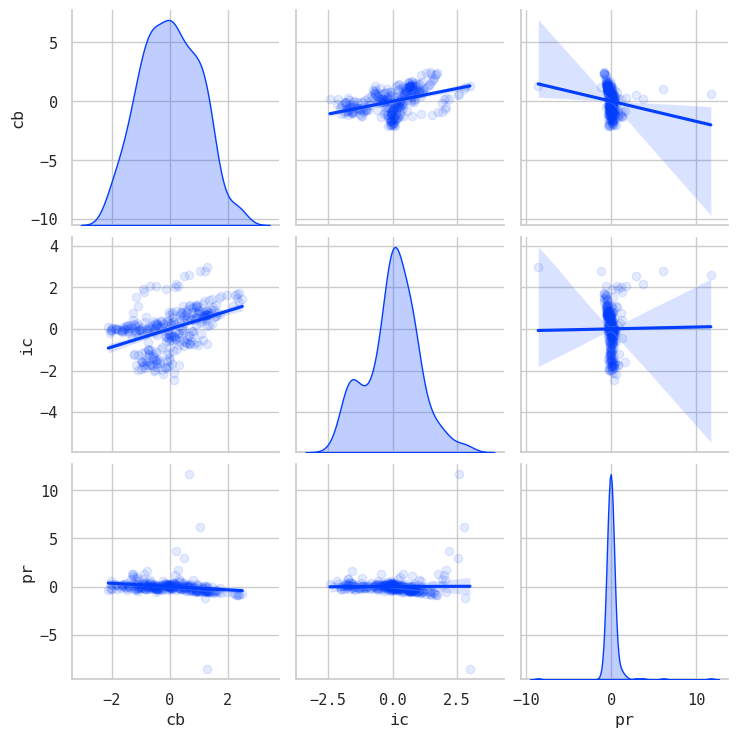

In [348]:
sns.pairplot(xy_yj_zs,kind="reg",diag_kind="kde",plot_kws={"scatter_kws":{"alpha":.1}})

In [519]:
poly=PolynomialFeatures()
x_poly=poly.fit_transform(x)
_ridge=Ridge()
_ridge.fit(x_poly,y)

Ridge()

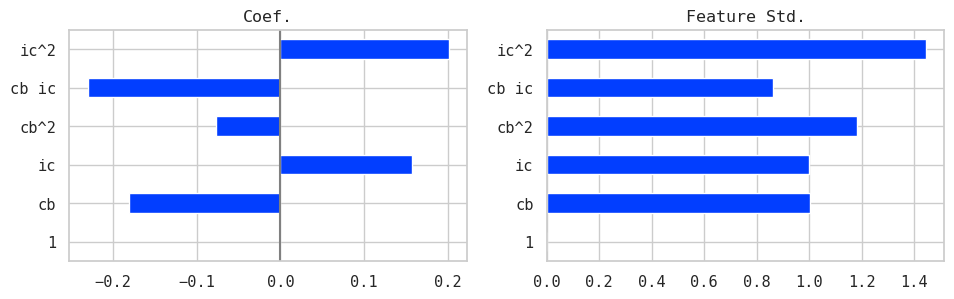

In [520]:
coefs=pd.DataFrame(data=_ridge.coef_,index=poly.get_feature_names_out(),columns=["Coef."])
_x_processed=pd.DataFrame(x_poly,columns=poly.get_feature_names_out())
fg,ax=plt.subplots(1,2,figsize=(10,3))
coefs.plot.barh(ax=ax[0],legend=False)
ax[0].axvline(x=0,color=".5")
ax[0].set_title("Coef.")
_x_processed.std().plot.barh(ax=ax[1])
ax[1].set_title("Feature Std.")
plt.subplots_adjust(right=1.,wspace=.2)

In [515]:
kfold=RepeatedKFold(n_splits=10,n_repeats=100,random_state=23301522)
cv=cross_validate(_ridge,x_poly,y,cv=kfold,scoring="r2",return_estimator=True,n_jobs=-1)

In [516]:
cv_coefs=pd.DataFrame(
    [estimator.coef_*_x_processed.iloc[train_idx].std() for
     estimator,(train_idx,_) in zip(cv["estimator"],kfold.split(x))],
    columns=poly.get_feature_names_out()
)

Text(0.5, 1.0, 'Ridge() Coef. Importance Volatility, KFold=1000')

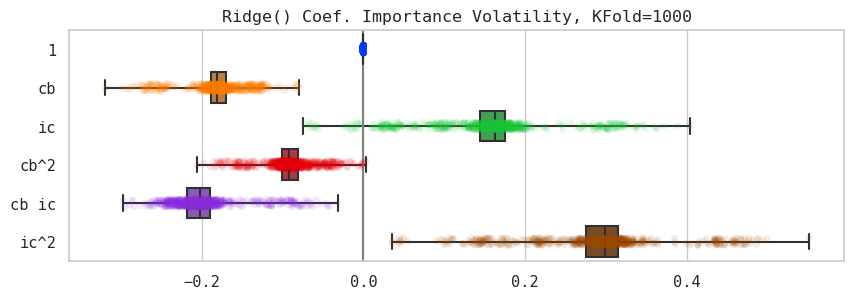

In [521]:
plt.subplots(figsize=(10,3))
sns.stripplot(cv_coefs,orient="h",alpha=.1)
sns.boxplot(cv_coefs,orient="h",saturation=.5,whis=10)
plt.axvline(x=0,color=".5")
plt.title(f"{_ridge} Coef. Importance Volatility, KFold={cv_coefs.shape[0]}")

In [522]:
alphas=np.logspace(-2,5,100)
per_alpha=[]
for _alpha in alphas:
    _cv=cross_validate(Ridge(_alpha),x_poly,y,cv=kfold,scoring="r2",return_estimator=True,n_jobs=-1)
    _coef=[estimator.coef_ for estimator in _cv["estimator"]]
    _coef_mean=np.mean(_coef,axis=0)
    _score=_cv["test_score"]
    _score_mean=np.mean(_score)
    per_alpha.append((np.array([_alpha]),np.array([_score_mean]),_coef_mean))
    del _cv["estimator"]

In [523]:
cols=["alpha","score"]
cols.extend(poly.get_feature_names_out())
per_alpha_df=pd.DataFrame([np.concatenate(q) for q in per_alpha],columns=cols)

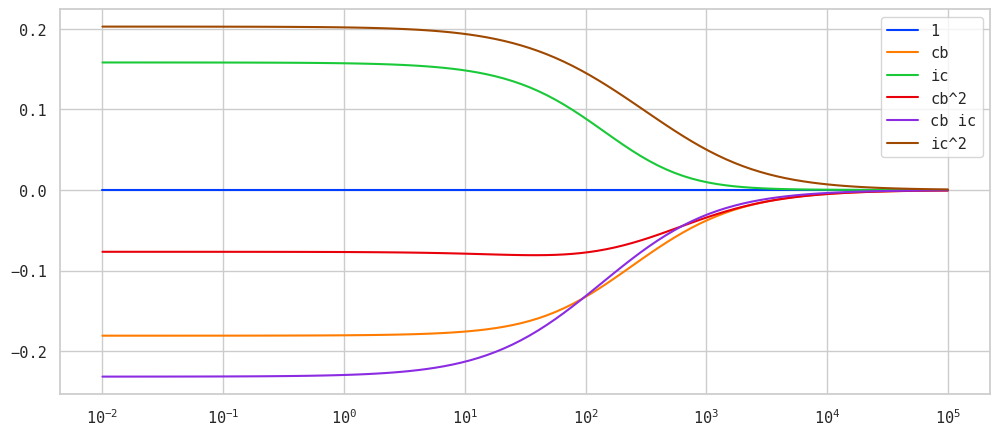

In [524]:
plt.semilogx(per_alpha_df.alpha,per_alpha_df.iloc[:,2:])
plt.legend(poly.get_feature_names_out())

205.65123083486515

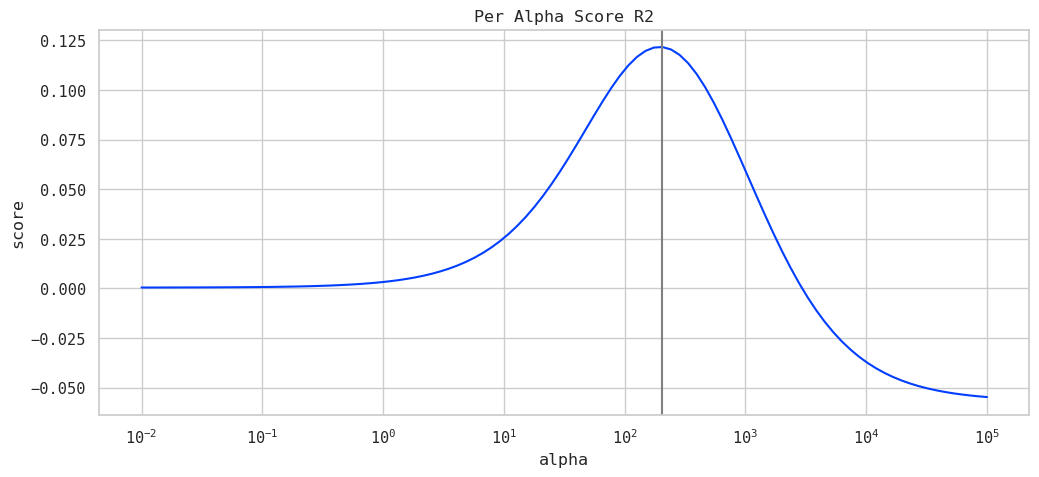

In [525]:
p=sns.lineplot(x=per_alpha_df.alpha,y=per_alpha_df.score)
p.set_xscale("log")
p.axvline(x=per_alpha_df.alpha[per_alpha_df.score.idxmax()],color=".5")
p.set_title("Per Alpha Score R2")
per_alpha_df.alpha[per_alpha_df.score.idxmax()]

In [526]:
RIDGE=Ridge(205.651)
RIDGE.fit(x_poly,y)

Ridge(alpha=205.651)

In [527]:
x_=xy_yj_zs.iloc[-1,:2].to_numpy().reshape(1,-1)
x_=poly.transform(x_)
y_=RIDGE.predict(x_)

c:\prog\lib\miniconda\envs\org\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [529]:
y_mean=(y_ * xy_yj_zs.pr.mean()) + xy_yj_zs.pr.mean()
y_mid =(y_ * xy_yj_zs.pr.median()) + xy_yj_zs.pr.median()

print("mean-based:",y_mean)
print("median-based:",y_mid)
print("pr lambda:",xy_yj_lambda["pr"])

def invert_yeojhonson(value, lmbda):
  if value>= 0 and lmbda == 0:
    return exp(value) - 1
  elif value >= 0 and lmbda != 0:
    return (value * lmbda + 1) ** (1 / lmbda) - 1
  elif value < 0 and lmbda != 2:
    return 1 - (-(2 - lmbda) * value + 1) ** (1 / (2 - lmbda))
  elif value < 0 and lmbda == 2:
    return 1 - exp(-value)

print("expected NFP delta of the nearest month:",invert_yeojhonson(y_mean,xy_yj_lambda["pr"]))

mean-based: [0.]
median-based: [-0.06175486]
pr lambda: 1.1156148929234415
expected NFP delta of the nearest month: [0.]


### 참고문헌
[Ben S. Bernanke, Bernanke's Lecture Serie](https://www.youtube.com/watch?v=E3fFg8XIS0k), 2012.  
[Ministry of Finance, 10-year Inflation-Indexed Bonds](https://www.mof.go.jp/english/policy/jgbs/topics/bond/10year_inflation/index.htm), December 11, 2022.  
SAS를 이용한 현대통계학 2e, 최병선, 2003.  
통계학 3e, 류근관, 2016.  
Eric C. Engstrom et al., The Near-Term Forward Yield Spread as a Leading Indicator: A Less Distorted Mirror, 2018.  
H. Clark et al., How Stable Is China’s Growth? Shedding Light on Sparse Data, 2020.  
Kevin L. Kliessen, Measuring Financial Market Stress, 2010.  
Board of Governors of the Federal Reserve System (US), Federal Funds Effective Rate [DFF], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
U.S. Employment and Training Administration, Initial Claims [ICSA], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
U.S. Bureau of Labor Statistics, Unemployment Rate [UNRATE], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
U.S. Bureau of Labor Statistics, All Employees, Total Nonfarm [PAYEMS], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
U.S. Bureau of Economic Analysis, Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index) [PCEPILFE], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
U.S. Bureau of Labor Statistics, Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average [CPILFESL], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
Ice Data Indices, LLC, ICE BofA US High Yield Index Option-Adjusted Spread [BAMLH0A0HYM2], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
U.S. Census Bureau, Advance Retail Sales: Retail Trade [RSXFS], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
U.S. Bureau of Economic Analysis, Real Gross Domestic Product [GDPC1], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
[Yahoo! API T&C](https://legal.yahoo.com/us/en/yahoo/terms/product-atos/apiforydn/index.html)  
[
ShamimaMoni / Inverse-yeo-johnson.ipynb](https://gist.github.com/ShamimaMoni/e06883bd0a6c0d94a208d3fa7ba5b18c)